In [1]:
def convert_gender(gender):
    if gender.startswith('male'):
        return 'male'
    elif gender.startswith('female'):
        return 'female'
    assert false, gender

def get_num(x):
    try:
        return int(x)
    except ValueError:
        try:
            return float(x)
        except ValueError:
            return float('nan')
    
def update_dict(d, key, row):
    empty_list = [0 for _ in row]
    d[key] = [get_num(row[i]) + d.get(key, empty_list)[i] for i in range(len(row))]

In [2]:
hab_control = dict()
exp_control = dict()
hab_treatment = dict()
exp_treatment = dict()

with open('data/output_data_long_videos_freeze_corrected.csv','r') as f:
    import csv
    reader = csv.reader(f)
    for row in reader:
        # rows of interest
        roi = row[7:22]

        # skip header
        if row[0] == 'tank_num':
            headings = [cell.strip() for cell in roi]
            print(f'Row of interest: {headings}')
            continue

        tank_num = row[0].strip()
        date = row[1].strip()
        pair_id = int(row[2])
        status = row[3].strip()
        phase = row[4].strip()
        cond = row[5].strip()
        subject = convert_gender(row[6].strip())

# These ones should be skipped, as the data for the first 4 observations are missing
# F1, 2017.04.28,5,S, habituation, treatment, male_A,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
# F1, 2017.04.28,5,S, habituation, treatment, female_A,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
# F1, 2017.04.28,6,F, habituation, treatment, male_B,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
# F1, 2017.04.28,6,F, habituation, treatment, female_B,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
# F1, 2017.05.01,6,F, experiment, treatment, male_A,7,0,4,3,2,0,0,0,0,0,0,0,0,136.91,44.824
# F1, 2017.05.01,6,F, experiment, treatment, female_A,4,1,2,0,2,0,0,0,0,0,0,0,0,136.91,43.243
# F1, 2017.05.01,8,S, experiment, treatment, male_B,0,2,2,5,0,0,0,0,0,0,2,0,1,92.59,24.271
# F1, 2017.05.01,8,S, experiment, treatment, female_B,0,19,2,3,4,0,0,0,0,0,2,0,0,53.718,16.91

# The first four rows are easy, as the data is missing (and triggers a ValueError).
# Use a special case to check the others.
        skip_rows = [
            ['F1', '2017.05.01', '6', 'F', 'experiment', 'treatment'],
            ['F1', '2017.05.01', '8', 'S', 'experiment', 'treatment']
        ]
        
        skip = False
        for skip_row in skip_rows:
            if all(a == b.strip() for a,b in zip(skip_row, row)):
                skip = True
                break
        # Disable the skipping for the moment
        # if skip:
            # print(f'Skipping row: {row}')
            # continue

        try:
            key = (pair_id, subject, status)
            if phase == 'habituation':
                if cond == 'control':
                    update_dict(hab_control, key, roi)
                elif cond == 'treatment':
                    update_dict(hab_treatment, key, roi)
                else:
                    assert false, row
            elif phase == 'experiment':
                if cond == 'control':
                    update_dict(exp_control, key, roi)
                elif cond == 'treatment':
                    update_dict(exp_treatment, key, roi)
                else:
                    assert false, row
            else:
                assert false, row

        except ValueError:
            print(f'Skipping row: {row} due to ValueError!')
            pass

Row of interest: ['app_neighbour', 'app_partner', 'fspr_neighbour', 'fspr_partner', 'cavity_neighbour', 'ST_neighbour', 'hd_neighbour', 'hd_partner', 'bars_neighbour', 'bars_partner', 'freeze_neighbour', 'sbend_neighbour', 'sbend_partner', 'l_partner', 'l_neighbour']


In [3]:
def calc_delta(hab_dict, exp_dict):
    # calculate hab - exp for control pairs
    assert hab_dict.keys() == exp_dict.keys(), f'diff: {set(hab_dict.keys()) ^ set(exp_dict.keys())}'
    combined = dict()

    for k, v in hab_dict.items():
        combined[k] = [hab - exp for hab, exp in zip(v, exp_dict[k])]
        # print(f'{k} -> {combined[k]}')

    return combined

control_values = calc_delta(hab_control, exp_control)
treatment_values = calc_delta(hab_treatment, exp_treatment)

def output_values(values):
    # now output the data to a csv file for further processing
    with open('output_values.csv','w') as f:
        f.write(f'pairid,gender,status,phase,{",".join(headings)}\n')
        for col, value in values:
            for k, v in value.items():
                key_str = ','.join(map(str, k))
                val_str = ','.join(map(str, v))
                f.write(f'{key_str},{col},{val_str}\n')

        print(f'Wrote {f.tell()} bytes')
    
output_values([('control', control_values), ('treatment', treatment_values)])

Wrote 13183 bytes


In [4]:
def calc_mannwhitneyu_test(control, treatment, col):
    from scipy import stats
    from numpy import array
    
    control_array = array([v[col] for v in control.values()])
    treatment_array = array([v[col] for v in treatment.values()])
    
    return stats.mannwhitneyu(control_array, treatment_array)

In [5]:
def do_test_boxplot(heading):
    i = headings.index(heading)
    print(f'Column {i+1}, {headings[i]}: {calc_mannwhitneyu_test(control_values, treatment_values, i)}')
    
    import matplotlib.pyplot as plt
    from math import isnan
    fig, ax = plt.subplots()
    ax.boxplot(
        [[v[i] for v in control_values.values() if not isnan(v[i])],
         [v[i] for v in treatment_values.values() if not isnan(v[i])]],
        labels=['control', 'treatment'],
        # positions=[1, 3]
    )
    ax.set(title=f'{heading}')
    # ax.set_ylim(0, 160)
    fig.savefig(f'fishy_stuff_t-tests-long_videos_{heading}.pdf', format='pdf')

In [6]:
for heading in ['app_neighbour', 'app_partner', 'freeze_neighbour', 'l_neighbour']:
    do_test_boxplot(heading)

Column 1, app_neighbour: MannwhitneyuResult(statistic=2213.0, pvalue=0.000379577471607895)
Column 2, app_partner: MannwhitneyuResult(statistic=2953.0, pvalue=0.18757263566188292)
Column 11, freeze_neighbour: MannwhitneyuResult(statistic=2990.5, pvalue=0.23635932789470943)
Column 15, l_neighbour: MannwhitneyuResult(statistic=3153.0, pvalue=0.43695747473457924)


In [7]:
from scipy import stats
import numpy

hab_control_i_values = numpy.array([v[0] for v in hab_control.values()])
exp_control_i_values = numpy.array([v[0] for v in exp_control.values()])
hab_treatment_i_values = numpy.array([v[0] for v in hab_treatment.values()])
exp_treatment_i_values = numpy.array([v[0] for v in exp_treatment.values()])

hab_control_n_values = numpy.array([v[1] for v in hab_control.values()])
exp_control_n_values = numpy.array([v[1] for v in exp_control.values()])
hab_treatment_n_values = numpy.array([v[1] for v in hab_treatment.values()])
exp_treatment_n_values = numpy.array([v[1] for v in exp_treatment.values()])
# How to do a t-test
# stats.ttest_rel(hab_control_values, exp_control_values)

In [8]:
from matplotlib.pyplot import hist

(array([16.,  6., 10.,  3.,  5.,  6.,  6.,  3.,  5.,  3.,  4.,  2.,  3.,
         1.,  3.,  2.,  0.,  0.,  0.,  2.]),
 array([  0. ,   6.5,  13. ,  19.5,  26. ,  32.5,  39. ,  45.5,  52. ,
         58.5,  65. ,  71.5,  78. ,  84.5,  91. ,  97.5, 104. , 110.5,
        117. , 123.5, 130. ]),
 <a list of 1 Patch objects>)

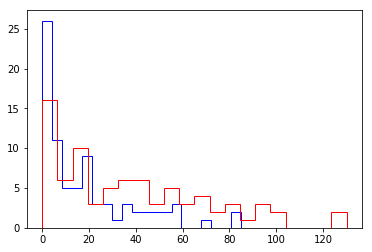

In [9]:
hist(hab_control_i_values,bins=20,histtype='step',color='blue')
hist(exp_control_i_values,bins=20,histtype='step',color='red')

/nix/store/9brkpb2ijn4z1vn18f5lsbvxnyqxp06i-python3-3.6.6-env/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
/nix/store/9brkpb2ijn4z1vn18f5lsbvxnyqxp06i-python3-3.6.6-env/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


ValueError: max must be larger than min in range parameter.

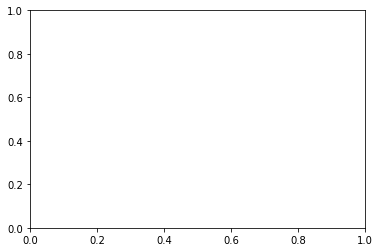

In [10]:
hist(hab_treatment_i_values,bins=20,histtype='step',color='blue')
hist(exp_treatment_i_values,bins=20,histtype='step',color='red')

In [ ]:
hist(hab_control_n_values,bins=20,histtype='step',color='blue')
hist(exp_control_n_values,bins=20,histtype='step',color='red')

In [ ]:
hist(hab_control_n_values,bins=20,histtype='step',color='blue')
hist(exp_control_n_values,bins=20,histtype='step',color='red')

### Control tests — Intruder

In [ ]:
print(stats.kstest(hab_control_i_values, 'norm'))
print(stats.kstest(exp_control_i_values, 'norm'))
print(stats.wilcoxon(hab_control_i_values, exp_control_i_values))

### Treatment tests — Intruder

In [ ]:
print(stats.kstest(hab_treatment_i_values, 'norm'))
print(stats.kstest(exp_treatment_i_values, 'norm'))
print(stats.wilcoxon(hab_treatment_i_values, exp_treatment_i_values))

### Control tests — Neighbour


In [ ]:
print(stats.kstest(hab_control_n_values, 'norm'))
print(stats.kstest(exp_control_n_values, 'norm'))
print(stats.wilcoxon(hab_control_n_values, exp_control_n_values))

### Treatment tests — Neighbour

In [ ]:
print(stats.kstest(hab_treatment_n_values, 'norm'))
print(stats.kstest(exp_treatment_n_values, 'norm'))
print(stats.wilcoxon(hab_treatment_n_values, exp_treatment_n_values))